# Data exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from yass.preprocess.filter import butterworth, whitening, whitening_matrix
from yass.geometry import (parse_geometry, find_channel_neighbors,
                                          n_steps_neigh_channels)
from yass.preprocess.detect import threshold_detection
from yass.preprocess.waveform import get_waveforms
from yass.preprocess.standarize import standarize, sd
from yass.preprocess.score import getPcaSS, getScore, getPCAProjection

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
spikeSizeMS = 4
srate = 20000
spike_size = int(np.round(spikeSizeMS*srate/2000))
BUFF = spike_size * 2
scale_to_save = 100
n_features = 3
n_channels = 7
observations = 100000

# Data loading

In [4]:
d = np.fromfile('/Users/Edu/dev/grossman/YASS/tests/sample_data/sample_100k.bin',
                dtype='int16')

In [5]:
d = d.reshape(observations, n_channels)

In [6]:
d.shape

(100000, 7)

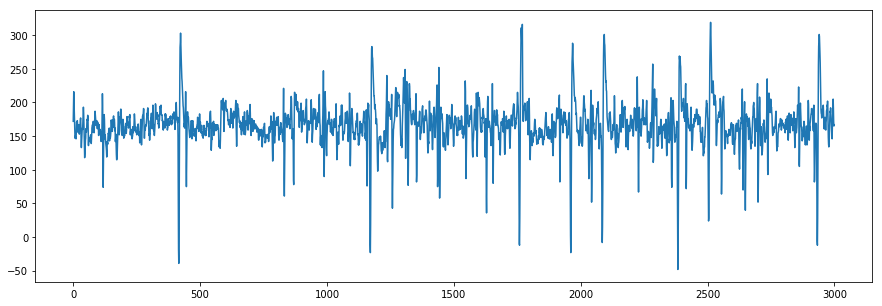

In [7]:
plt.plot(d[:3000, 2])

# Butterworth filter

In [8]:
filtered = butterworth(d, low_freq=300, high_factor=0.1,
                       order=3, sampling_freq=20000)

In [9]:
filtered[:3, :3]

array([[  1.93139771,   2.15791966,   2.05061979],
       [ 11.41594077,  12.76404663,  12.13049005],
       [ 32.62257251,  36.31202602,  34.65120104]])

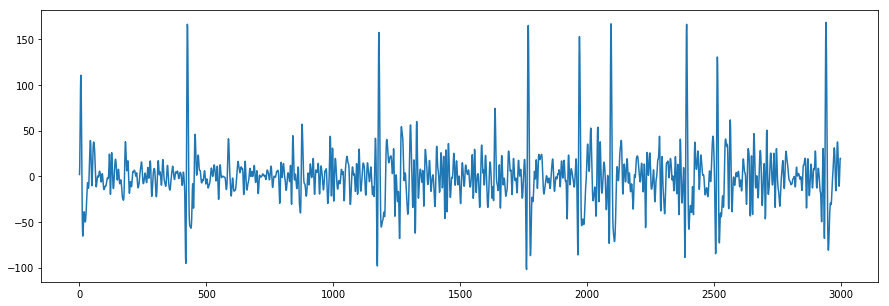

In [10]:
plt.plot(filtered[:3000, 2])

# Standarization

In [11]:
_sd = sd(filtered, srate)
standarized = standarize(filtered, _sd)

In [12]:
standarized[:3, :3]

array([[ 0.1135658 ,  0.1647945 ,  0.14002903],
       [ 0.67125501,  0.97475582,  0.82834505],
       [ 1.91820068,  2.7730515 ,  2.36619879]])

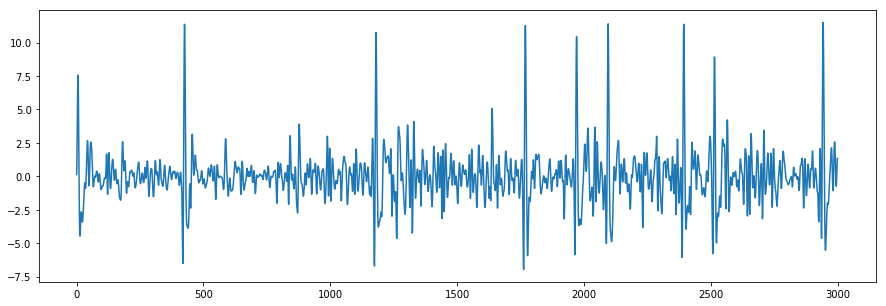

In [13]:
plt.plot(standarized[:3000, 2])

# Geometry

In [14]:
geom = parse_geometry('/users/Edu/data/yass/ej49_geometry1.txt', n_channels)

In [15]:
neighbors = find_channel_neighbors(geom, radius=70)

In [16]:
neighbors_big = n_steps_neigh_channels(neighbors, steps=2)

# Threshold detection

In [17]:
detected = threshold_detection(standarized, neighbors, spike_size, 5)

In [18]:
index = detected[np.logical_and(detected[:,0] > BUFF, detected[:,0] < (standarized.shape[0] - BUFF) )]

# Whitening

In [19]:
Q = whitening_matrix(standarized, neighbors, spike_size)

In [20]:
whitened = whitening(standarized, Q)

In [30]:
whitened.ndim

2

# Getting waveforms

In [22]:
score, clr_idx, spt = get_waveforms(whitened, neighbors,
                                    index, 0, None, spike_size,
                                    n_features, None, None)

In [113]:
clr_idx

[array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32)]

# Getting PCA projections

In [23]:
ss, n_spikes = getPcaSS(whitened, spt, spike_size, BUFF)

In [24]:
ss.shape

(81, 81, 7)

In [25]:
ss[:, :, 0][:5,:5]

array([[ 2.0107075 ,  1.41753522,  0.59246118, -0.13424957, -0.55618273],
       [ 1.41753522,  2.19438639,  2.48148061,  2.24336974,  1.663747  ],
       [ 0.59246118,  2.48148061,  3.74434439,  4.01705442,  3.42436951],
       [-0.13424957,  2.24336974,  4.01705442,  4.65590494,  4.21149352],
       [-0.55618273,  1.663747  ,  3.42436951,  4.21149352,  4.01494628]])

In [26]:
np.sum(ss,2).shape

(81, 81)